In [1]:
import os
import time

import stempeg
import mir_eval
from tqdm.auto import tqdm

import librosa
import librosa.display
import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

In [2]:
down_sr = 8192 # 8192Hz
window_size = 1024
hop_length = 768
patch_size = 128
SAMPLING_STRIDE = 10

### Helper functions

In [3]:
def getMonoAudio(audio_path):
    # read stem file
    stem_data = stempeg.read_stems(audio_path)
    music_data, sampling_rate = stem_data
    
    mix, drum, bass, rest, vox = music_data
    inst = mix - vox  # instrumetal track is computed as mix minus vocal
    
    # stereo -> mono
    mix_mono = librosa.to_mono(mix.transpose())
    vox_mono = librosa.to_mono(vox.transpose())
    inst_mono = librosa.to_mono(inst.transpose())
    
    return mix_mono, vox_mono, inst_mono


def getSpectrogram(y_mix, y_vox, y_inst, down_sr, orig_sr=44100) :
    # Downsampling
    y_mix = librosa.core.resample(y_mix, orig_sr, down_sr)
    y_vox = librosa.core.resample(y_vox, orig_sr, down_sr)
    y_inst = librosa.core.resample(y_inst, orig_sr, down_sr)

    # take absolute
    S_mix = np.abs(librosa.stft(y_mix,n_fft=window_size,hop_length=hop_length)).astype(np.float32)
    S_vox = np.abs(librosa.stft(y_vox,n_fft=window_size,hop_length=hop_length)).astype(np.float32)
    S_inst = np.abs(librosa.stft(y_inst,n_fft=window_size,hop_length=hop_length)).astype(np.float32)
    
    # Normalize
    norm = S_mix.max()
    S_mix /= norm
    S_vox /= norm
    S_inst /= norm
    
    return S_mix, S_vox, S_inst
    

# separate magnitude and phase from spectrograms
def Magnitude_phase(spectrogram) :
    Magnitude_list = []
    Phase_list = []
    
    for X in spectrogram :
        mag, phase = librosa.magphase(X)
        Magnitude_list.append(mag)
        Phase_list.append(phase)
        
    return Magnitude_list, Phase_list


# sample magnitude spectrograms of shape 512*128
def sampling(X_mag, Y_mag) :
    X, y = [], []
    
    for mix, target in zip(X_mag,Y_mag) :
        starts = np.random.randint(0, mix.shape[1] - patch_size, (mix.shape[1] - patch_size) // SAMPLING_STRIDE)
        
        for start in starts:
            end = start + patch_size
            X.append(mix[1:, start:end, np.newaxis])
            y.append(target[1:, start:end, np.newaxis])
            
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

## Preprocess

In [4]:
def preprocess(mode):
    '''preprocess musdb18 dataset, mode = "train" or "test"'''
    tic = time.time()
    folder_name = 'musdb18'+'/'+mode
    music_dir_list = os.listdir(folder_name)

    for music_dir in tqdm(music_dir_list):
        audio_path = folder_name+'/'+music_dir
        
        # get mono samples given path to stem file
        mix, vox, inst = getMonoAudio(audio_path)
        
        # get spectrograms
        s_mix, s_vox, s_inst = getSpectrogram(mix, vox, inst, down_sr)

        music_title = music_dir[:-9]
        save_path = 'spec_'+mode
        
        # create a directory to save if not exists
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # save numpy files
        np.save(save_path+'/'+music_title+'.mix', s_mix)
        np.save(save_path+'/'+music_title+'.vox', s_vox)
        np.save(save_path+'/'+music_title+'.inst', s_inst)
    
    toc = time.time()
    print(f'Finished preprocessing in {toc-tic:.2f}s')
    
    return

In [ ]:
preprocess('train')

In [ ]:
preprocess('test')

## Load data

In [5]:
def load(mode):
    '''load saved npy from path, mode = "train" or "test"'''
    folder_name = 'spec_'+mode
    X, y_vox, y_inst = [], [], []
    spectrogram_dir_list = os.listdir(folder_name)
    
    # for each spectrogram(.npy) saved in directory
    for spectrogram_dir in tqdm(spectrogram_dir_list):
        file_type = spectrogram_dir.split('.')[-2]
        
        # load mix file in X
        if file_type == 'mix':
            sp_mix = np.load(folder_name+'/'+spectrogram_dir)
            X.append(sp_mix)
        
        # load vocal file in y_vox
        elif file_type == 'vox':
            sp_vocal = np.load(folder_name+'/'+spectrogram_dir)
            y_vox.append(sp_vocal)
        
        # load instrument file in y_inst
        elif file_type == 'inst':
            sp_inst = np.load(folder_name+'/'+spectrogram_dir)
            y_inst.append(sp_inst)
            
    return X, y_vox, y_inst

### Load train data

In [6]:
# load train data
X_train, y_vox_train, y_inst_train = load('train')

In [7]:
# extract magnitude from train
X_mag_train, _ = Magnitude_phase(X_train)
y_vox_mag_train, _ = Magnitude_phase(y_vox_train)
y_inst_mag_train, _ = Magnitude_phase(y_inst_train)

# sample as 512*128
train_x_vox, train_y_vox = sampling(X_mag_train, y_vox_mag_train)
train_x_inst, train_y_inst = sampling(X_mag_train, y_inst_mag_train)

In [8]:
train_x_vox.shape, train_y_vox.shape

((23077, 512, 128, 1), (23077, 512, 128, 1))

### Load test data

In [9]:
# load test data
X_test, y_vox_test, y_inst_test = load('test')

In [10]:
# extract magnitude from test
X_mag_test, _ = Magnitude_phase(X_test)
y_vox_mag_test, _ = Magnitude_phase(y_vox_test)
y_inst_mag_test, _ = Magnitude_phase(y_inst_test)

# sample as 512*128
x_test_vox, y_test_vox = sampling(X_mag_test, y_vox_mag_test)
x_test_inst, y_test_inst = sampling(X_mag_test, y_inst_mag_test)

In [11]:
x_test_vox.shape, y_test_vox.shape

((12637, 512, 128, 1), (12637, 512, 128, 1))

sample input: torch.Size([512, 128])


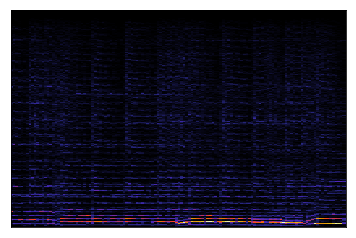

In [12]:
# check loaded data
img = train_x_vox[0]
img = img.squeeze()
librosa.display.specshow(img, cmap='CMRmap')
img = torch.Tensor(img)
print('sample input: {}'.format(img.shape))

In [13]:
ipd.Audio(librosa.istft(img.numpy(), hop_length=hop_length), rate=8192)

## Model

In [14]:
# downward convolution class
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        
        self.down = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
    def forward(self, x):
        x = self.down(x)
        return x


# upward convolution class
class up(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0, concat=True, activation='relu'):
        super(up, self).__init__()
        self.concat = concat
        
        if activation == 'relu':
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=5, stride=2, padding=2, output_padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p_drop))
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=5, stride=2, padding=2, output_padding=1),
                nn.BatchNorm2d(out_ch),
                nn.Sigmoid(),
                nn.Dropout(p_drop))

    def forward(self, x1, x2):
        if self.concat:
            x1 = self.up(x1)
            x = torch.cat([x2, x1], dim=1)
        else:
            x = self.up(x1)
            
        return x


# Deep-U-Net model
class deepUNet(nn.Module):
    
    def __init__(self, in_ch):
        super(deepUNet, self).__init__()
        self.down1 = down(in_ch, 16)
        self.down2 = down(16, 32)
        self.down3 = down(32, 64)
        self.down4 = down(64, 128)
        self.down5 = down(128, 256)
        self.down6 = down(256, 512)
        self.up1 = up(512, 256, 0.5)
        self.up2 = up(512, 128, 0.5)
        self.up3 = up(256, 64, 0.5)
        self.up4 = up(128, 32)
        self.up5 = up(64, 16)
        self.up6 = up(32, 1, concat=False, activation='sig')

    def forward(self, x):
        x = x.view(-1, 1, 512, 128)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        
        m = self.up1(x6, x5)
        m = self.up2(m, x4)
        m = self.up3(m, x3)
        m = self.up4(m, x2)
        m = self.up5(m, x1)
        m = self.up6(m, x)
        out = m*x
        out = out.view(out.size(0), out.size(2), out.size(3), -1)
        
        # returns masked output, mask, and original input
        return out, m, x

## Confirm that model works

In [15]:
model = deepUNet(1)
print('input size: {}'.format(img.shape))
out, m, x = model(img)
print('output size: {}'.format(out.shape))

input size: torch.Size([512, 128])
output size: torch.Size([1, 512, 128, 1])


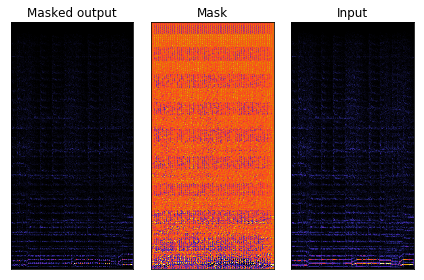

In [16]:
# masked output = mask*input
out = out.squeeze().detach().numpy()
m = m.squeeze().detach().numpy()
x = x.squeeze().detach().numpy()

plt.subplot(1,3,1)
librosa.display.specshow(out, cmap='CMRmap')
plt.title('Masked output')

plt.subplot(1,3,2)
librosa.display.specshow(m, cmap='CMRmap')
plt.title('Mask')

plt.subplot(1,3,3)
librosa.display.specshow(x, cmap='CMRmap')
plt.title('Input')

plt.tight_layout()
plt.show()

## Split train and valid

In [17]:
split_frac = 0.75
split_idx = int(split_frac*len(train_x_vox))

# split data into train and valid for voices and instruments
x_train_vox, x_valid_vox = train_x_vox[:split_idx], train_x_vox[split_idx:]
y_train_vox, y_valid_vox = train_y_vox[:split_idx], train_y_vox[split_idx:]

x_train_inst, x_valid_inst = train_x_inst[:split_idx], train_x_inst[split_idx:]
y_train_inst, y_valid_inst = train_y_inst[:split_idx], train_y_inst[split_idx:]

## print out the shapes of resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(x_train_vox.shape), 
      "\nValidation set: \t{}".format(x_valid_vox.shape),
      "\nTest set: \t\t{}".format(x_test_vox.shape))

			Feature Shapes:
Train set: 		(17307, 512, 128, 1) 
Validation set: 	(5770, 512, 128, 1) 
Test set: 		(12637, 512, 128, 1)


## Dataset & hyperparams

In [67]:
# init hyperparameters
class Hyperparameters(object):
    def __init__(self):
        self.batch_size = 100
        self.num_epochs = 50
        self.learning_rate = 0.1
        self.stopping_rate = 1e-5
        self.decay_ratio = 5e-4
        self.factor = 0.5
        self.scheduler_patience = 3
        self.stopper_patience = 20
        
    def print_hyperparams(self):
        print('-'*10)
        print('Hyperparameter settings...')
        print('-'*10)
        for var in vars(self):
            value = getattr(hparams, var)
            print(var+': '+str(value))
        print('-'*10)

hparams = Hyperparameters()

# prepare data for vocal separation
train_data_vox = TensorDataset(torch.from_numpy(x_train_vox), torch.from_numpy(y_train_vox))
valid_data_vox = TensorDataset(torch.from_numpy(x_valid_vox), torch.from_numpy(y_valid_vox))
test_data_vox = TensorDataset(torch.from_numpy(x_test_vox), torch.from_numpy(y_test_vox))

dataloaders_vox = {
    'train': DataLoader(train_data_vox, shuffle=True, batch_size=hparams.batch_size),
    'valid': DataLoader(valid_data_vox, shuffle=True, batch_size=hparams.batch_size),
    'test': DataLoader(test_data_vox, shuffle=False, batch_size=hparams.batch_size)
}

# prepare data for instrumental separation
train_data_inst = TensorDataset(torch.from_numpy(x_train_inst), torch.from_numpy(y_train_inst))
valid_data_inst = TensorDataset(torch.from_numpy(x_valid_inst), torch.from_numpy(y_valid_inst))
test_data_inst = TensorDataset(torch.from_numpy(x_test_inst), torch.from_numpy(y_test_inst))

dataloaders_inst = {
    'train': DataLoader(train_data_inst, shuffle=True, batch_size=hparams.batch_size),
    'valid': DataLoader(valid_data_inst, shuffle=True, batch_size=hparams.batch_size),
    'test': DataLoader(test_data_inst, shuffle=False, batch_size=hparams.batch_size)
}

# set device to cuda if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# initialize model, criterion, optimizer, and scheduler with hyperparams
def initialize(hparams):
    model = deepUNet(1)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hparams.factor,
                                  patience=hparams.scheduler_patience, verbose=True)
    
    model = model.cuda(device)
    criterion = criterion.cuda(device)
    
    return model, criterion, optimizer, scheduler

## Train model

In [58]:
def train(model, train_loader, device, optimizer, criterion):
    running_loss = 0.0
    batch_losses = []
    model.train()

    # for each batch in training set
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        # set gradients to zero
        optimizer.zero_grad()
        
        # get predictions and compute loss
        pred, _, _ = model(x)
        loss = criterion(pred, y)

        # backpropagate
        loss.backward()
        optimizer.step()

        # compute loss stats
        batch_loss_total = loss.item()*x.size(0)
        running_loss += batch_loss_total

        batch_loss = batch_loss_total/train_loader.batch_size
        batch_losses.append(batch_loss)
        
    return running_loss, batch_losses


def validate(model, valid_loader, device, criterion):
    running_loss = 0.0
    model.eval()

    # for each batch in validation set
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)

        # get predictions and compute loss
        pred, _, _ = model(x)
        loss = criterion(pred, y)

        # compute loss stats
        running_loss += loss.item()*x.size(0)
        
    return running_loss

## Early stopper class

In [59]:
# from: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, seed, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.seed = seed
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoints'+'/'+'checkpoint_{}_best.pt'.format(self.seed))
        self.val_loss_min = val_loss


def early_stop(loss, optimizer, scheduler, stopping_rate):
    '''
    reduces learning rate by a factor if validation loss doesn't improve after a given patience,
    but only during the learning rate is higher than the stopping rate.
    '''
    scheduler.step(loss)
    learning_rate = optimizer.param_groups[0]['lr']
    
    return learning_rate < stopping_rate

## Train with early stopping + LR scheduler

In [60]:
def run(device, hparams, dataloaders, seed=None):
    
    # save starting time
    start = time.time()
    
    # set seed for reproducibility
    if seed == None:        
        seed = np.random.randint(10000)
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    
    print(f'Training with seed: {seed}...')
    hparams.print_hyperparams()
    
    # initialize training
    model, criterion, optimizer, scheduler = initialize(hparams)
    train_loader = dataloaders['train']
    valid_loader = dataloaders['valid']
    
    # initialize early stopping
    early_stopping = EarlyStopping(seed, patience=hparams.stopper_patience, verbose=True)
    
    # make empty lists to store results
    train_loss, valid_loss = [], []
    train_loss_batch = []
    
    # for each epoch
    current_epoch = -1
    for epoch in range(hparams.num_epochs):
        tic = time.time()
        print(f'Epoch {epoch+1}/{hparams.num_epochs}', end=': ')
            
        # train with training set
        running_loss, batch_losses = train(model, train_loader, device, optimizer, criterion)
        
        epoch_loss = running_loss/len(train_loader.dataset)
        train_loss_batch.extend(batch_losses)
        train_loss.append(epoch_loss)

        # evaluate with validation set after training
        running_loss = validate(model, valid_loader, device, criterion)
        
        eval_loss = running_loss/len(valid_loader.dataset)
        valid_loss.append(eval_loss)

        toc = time.time()
        current_epoch = epoch
        print(f'{toc-tic:.2f}s/epoch | Train loss: {epoch_loss:.6f} & Val. loss: {eval_loss:.6f}')

        # save model if validation loss has improved
        early_stopping(eval_loss, model)
        
        # check first if validation loss has not improved for a given number of patience,
        # or if learning rate has dropped below the stopping rate,
        # and stop training if any one of two conditions is satisfied
        if early_stopping.early_stop or early_stop(eval_loss, optimizer, scheduler, hparams.stopping_rate):
            print('Early stopping...')
            break

        # continue training otherwise
        else:
            continue
            
    end = time.time()
    print(f'Training finished in {end-start:.2f}s for {current_epoch+1} epochs...')
    
    # save last model
    torch.save(model.state_dict(), 'checkpoints'+'/'+'checkpoint_{}_last.pt'.format(seed))
        
    return (train_loss, valid_loss, train_loss_batch), seed, model

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# do training for vocal separation
vox_losses, vox_seed, vox_model = run(device, hparams, dataloaders_vox, seed=None)
vox_train_loss, vox_valid_loss, vox_train_loss_batch = vox_losses

Training with seed: 4089...
----------
Hyperparameter settings...
----------
batch_size: 100
num_epochs: 50
learning_rate: 0.1
stopping_rate: 1e-05
decay_ratio: 0.0005
factor: 0.5
scheduler_patience: 3
stopper_patience: 20
----------
Epoch 1/50: 50.02s/epoch | Train loss: 0.002697 & Val. loss: 0.003278
Validation loss decreased (inf --> 0.003278).  Saving model ...
Epoch 2/50: 49.49s/epoch | Train loss: 0.002202 & Val. loss: 0.003126
Validation loss decreased (0.003278 --> 0.003126).  Saving model ...
Epoch 3/50: 49.49s/epoch | Train loss: 0.002023 & Val. loss: 0.003020
Validation loss decreased (0.003126 --> 0.003020).  Saving model ...
Epoch 4/50: 49.49s/epoch | Train loss: 0.001904 & Val. loss: 0.002905
Validation loss decreased (0.003020 --> 0.002905).  Saving model ...
Epoch 5/50: 49.58s/epoch | Train loss: 0.001816 & Val. loss: 0.002929
EarlyStopping counter: 1 out of 20
Epoch 6/50: 49.74s/epoch | Train loss: 0.001753 & Val. loss: 0.003272
EarlyStopping counter: 2 out of 20
Epoch

In [ ]:
# do training for instrumental separation
inst_losses, inst_seed, inst_model = run(device, hparams, dataloaders_inst, seed=None)
inst_train_loss, inst_valid_loss, inst_train_loss_batch = inst_losses

## Evaluate model

In [23]:
def test(model, criterion, test_loader, device, seed, mode='last'):
    '''
    S_e = estimated isolated signal, S_r = reference isolated signal, S_m = mixed signal
    '''
    model.eval()
    S_e, S_r, S_m = [], [], []
    
    # load best or last model for the given seed
    if mode == 'best':
        model.load_state_dict(torch.load('checkpoints'+'\\'+'checkpoint_{}_best.pt'.format(seed)))
    elif mode == 'last':
        model.load_state_dict(torch.load('checkpoints'+'\\'+'checkpoint_{}_last.pt'.format(seed)))
    
    # input = mixed, target = reference
    loop = tqdm(test_loader, desc='Testing...', unit='batches')
    for s_m, s_r in loop:
        s_m = s_m.to(device)
        s_r = s_r.to(device)
        
        # output = estimated
        s_e, _, _ = model(s_m)
        loss = criterion(s_e, s_r)
            
        loop.set_postfix_str(f'test loss={loss.item():.6f}')
        
        S_e.extend(s_e.detach().cpu().clone().numpy())
        S_r.extend(s_r.detach().cpu().clone().numpy())
        S_m.extend(s_m.detach().cpu().clone().numpy())
        
    return S_e, S_r, S_m

In [116]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# initiate models
vox_model, inst_model = deepUNet(1), deepUNet(1)
vox_model, inst_model = vox_model.cuda(device), inst_model.cuda(device)

vox_seed, inst_seed = 4662, 164

vox_model.load_state_dict(torch.load('checkpoints'+'\\'+'checkpoint_{}_best.pt'.format(vox_seed)))
inst_model.load_state_dict(torch.load('checkpoints'+'\\'+'checkpoint_{}_best.pt'.format(inst_seed)))

In [117]:
temp, _ = dataloaders_vox['test'].dataset[0]
temp = temp.to(device)
out_vox, m_vox, x_vox = vox_model(temp)

In [118]:
from torchsummary import summary

summary(vox_model, temp.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
              down-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
              down-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
             down-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

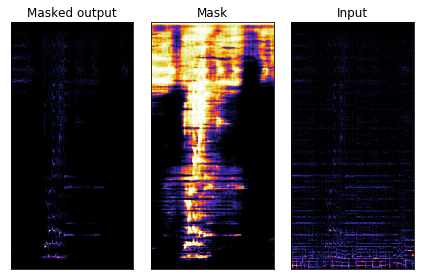

In [77]:
# masked output = mask*input
out_vox = out_vox.squeeze().detach().cpu().numpy()
m_vox = m_vox.squeeze().detach().cpu().numpy()
x_vox = x_vox.squeeze().detach().cpu().numpy()

plt.subplot(1,3,1)
librosa.display.specshow(out_vox, cmap='CMRmap')
plt.title('Masked output')

plt.subplot(1,3,2)
librosa.display.specshow(m_vox, cmap='CMRmap')
plt.title('Mask')

plt.subplot(1,3,3)
librosa.display.specshow(x_vox, cmap='CMRmap')
plt.title('Input')

plt.tight_layout()
plt.show()

In [78]:
temp, _ = dataloaders_inst['test'].dataset[0]
temp = temp.to(device)
out_inst, m_inst, x_inst = inst_model(temp)

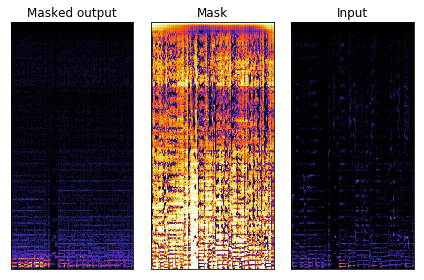

In [79]:
# masked output = mask*input
out_inst = out_inst.squeeze().detach().cpu().numpy()
m_inst = m_inst.squeeze().detach().cpu().numpy()
x_inst = x_inst.squeeze().detach().cpu().numpy()

plt.subplot(1,3,1)
librosa.display.specshow(out_inst, cmap='CMRmap')
plt.title('Masked output')

plt.subplot(1,3,2)
librosa.display.specshow(m_inst, cmap='CMRmap')
plt.title('Mask')

plt.subplot(1,3,3)
librosa.display.specshow(x_inst, cmap='CMRmap')
plt.title('Input')

plt.tight_layout()
plt.show()

In [80]:
criterion = nn.L1Loss()
criterion = criterion.cuda(device)

# get input, target, and output for both vocals and instrumentals
S_e_vox, S_r_vox, S_m_vox = test(vox_model, criterion, dataloaders_vox['test'], device, vox_seed, mode='best')
S_e_inst, S_r_inst, S_m_inst = test(inst_model, criterion, dataloaders_inst['test'], device, inst_seed, mode='best')

estm_vox = np.asarray(S_e_vox).squeeze()
true_vox = np.asarray(S_r_vox).squeeze()

estm_inst = np.asarray(S_e_inst).squeeze()
true_inst = np.asarray(S_r_inst).squeeze()

true_mix_vox = np.asarray(S_m_vox).squeeze()
true_mix_inst = np.asarray(S_m_inst).squeeze()

In [109]:
ipd.Audio(librosa.istft(true_mix_vox[1], hop_length//2), rate=down_sr)

In [87]:
ipd.Audio(librosa.istft(true_mix_inst[0], hop_length), rate=down_sr)

In [110]:
ipd.Audio(librosa.istft(true_vox[1], hop_length//2), rate=down_sr)

In [111]:
ipd.Audio(librosa.istft(estm_vox[1], hop_length//2), rate=down_sr)

In [92]:
ipd.Audio(librosa.istft(true_inst[0], hop_length), rate=down_sr)

In [93]:
ipd.Audio(librosa.istft(estm_inst[0], hop_length), rate=down_sr)

## Compute evaluation metrics

In [83]:
'''
Use SDR, SIR, SAR, and NSDR = SDR(S_e, S_r) - SDR(S_m, S_r), where
S_e = estimated isolated signal,
S_r = reference isolated signal,
S_m = mixed signal
'''

true_vox_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(true_vox)])
estm_vox_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(estm_vox)])

true_inst_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(true_inst)])
estm_inst_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(estm_inst)])

true_mix_vox_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(true_mix_vox)])
true_mix_inst_seq = np.asarray([librosa.istft(spec, hop_length) for spec in tqdm(true_mix_inst)])

In [84]:
def remove_silent(true, estm, mix):
    true_list, estm_list, mix_list = [], [], []
    
    for i, (true_sig, estm_sig, mix_sig) in tqdm(enumerate(zip(true, estm, mix))):
        if not np.count_nonzero(true_sig) or not np.count_nonzero(estm_sig):
            pass
        else:
            true_list.append(true_sig)
            estm_list.append(estm_sig)
            mix_list.append(mix_sig)
            
    return np.asarray(true_list), np.asarray(estm_list), np.asarray(mix_list)

true_vox_nonzero, estm_vox_nonzero, true_vox_mix_nonzero = remove_silent(true_vox_seq, estm_vox_seq, true_mix_vox_seq)
true_inst_nonzero, estm_inst_nonzero, true_inst_mix_nonzero = remove_silent(true_inst_seq, estm_inst_seq, true_mix_inst_seq)

In [ ]:
np.save('D:musdb-out/estm_vox_nonzero', estm_vox_nonzero)
np.save('D:musdb-out/true_vox_nonzero', true_vox_nonzero)

In [ ]:
np.save('D:musdb-out/true-mix', true_mix_vox)

reference_sources[n] should be an ndarray of samples of the n'th reference source

estimated_sources[n] should be the same for the n'th estimated source

(sdr, sir, sar, perm) = mir_eval.separation.bss_eval_sources(reference_sources, estimated_sources)

In [101]:
# mir_eval.separation.MAX_SOURCES = 1e6
# NSDR = SDR(S_e, S_r) - SDR(S_m, S_r)
# bss_eval_sources(reference_sources, estimated_sources, compute_permutation=True)

def compute_eval(mix, true, estm, idx):
    print('Computing evaluation metrics...')
    tic = time.time()
    sdr1, sir1, sar1, _ = mir_eval.separation.bss_eval_sources(true[:idx], estm[:idx], compute_permutation=False)
    sdr2, sir2, sar2, _ = mir_eval.separation.bss_eval_sources(true[:idx], mix[:idx], compute_permutation=False)
    
    nsdr = sdr1 - sdr2
    nsir = sir1 - sir2
    nsar = sar1 - sar2
    
    toc = time.time()
    print(f'Process completed in {toc-tic:.2f}s')
    
    sdr = (nsdr, sdr1, sdr2)
    sir = (nsir, sir1, sir2)
    sar = (nsar, sar1, sar2)
    
    return sdr, sir, sar

In [102]:
sdr_vox, sir_vox, sar_vox = compute_eval(true_vox_mix_nonzero, true_vox_nonzero, estm_vox_nonzero, 20)

Computing evaluation metrics...
Process completed in 215.53s


In [103]:
# 20 > 215.53s
np.mean(sdr_vox[0]), np.mean(sir_vox[1]), np.mean(sar_vox[1])

(5.320792628211456, 11.665507488958387, 4.4977720372891135)

In [ ]:
sdr_inst, sir_inst, sar_inst = compute_eval(true_inst_nonzero, estm_inst_nonzero, 40)

In [ ]:
# 30 > 429.86s
np.mean(sdr_inst), np.mean(sir_inst), np.mean(sar_inst)